<a href="https://colab.research.google.com/github/bksgupta/fastai-v3/blob/master/lesson3_head_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [38]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 29.6MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


## Getting and converting the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [5]:
fname = '09/frame_00667_rgb.jpg'

In [6]:
f'{str(fname)[:-7]}'

'09/frame_00667_'

In [7]:
path/f'{str(fname)[:-7]}pose.txt'

PosixPath('/root/.fastai/data/biwi_head_pose/09/frame_00667_pose.txt')

In [8]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

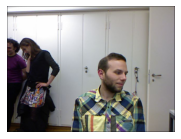

In [9]:
img = open_image(path/fname)
img.show()

In [10]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [11]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [12]:
get_ctr(fname)

tensor([263.9104, 428.5814])

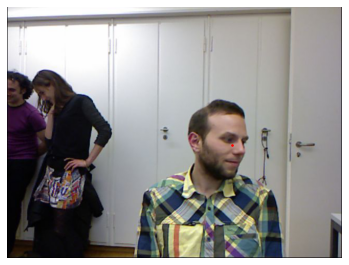

In [13]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [14]:
a = path/'01'
a.ls()

[PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00082_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00492_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00312_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00227_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00126_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00483_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00271_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00455_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00226_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00015_rgb.jpg'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00109_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00376_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_00493_pose.txt'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01/frame_0029

In [15]:
path

PosixPath('/root/.fastai/data/biwi_head_pose')

In [16]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

In [17]:
data.train_ds[0][0].shape

torch.Size([3, 120, 160])

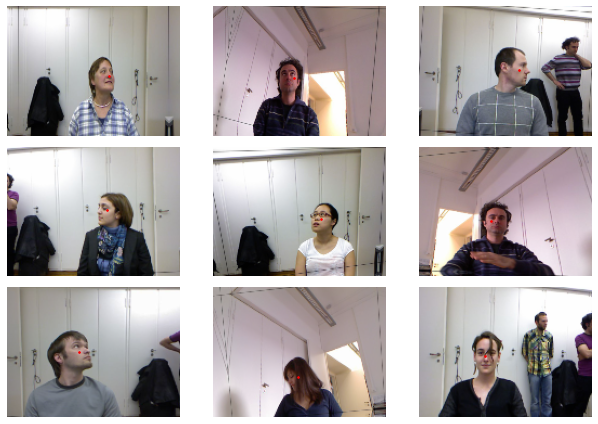

In [18]:
data.show_batch(3, figsize=(9,6))

## Train model

In [19]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


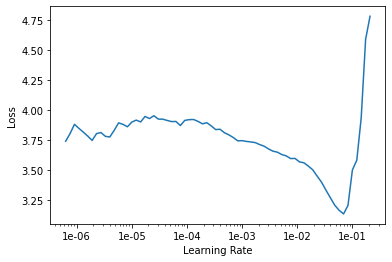

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr = 2e-2

In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.122528,0.028355,03:03
1,0.041804,0.001967,02:57
2,0.014015,0.004536,02:57
3,0.008460,0.002062,02:58
4,0.006617,0.001123,02:56


In [23]:
learn.save('stage-1')

In [24]:
learn.load('stage-1');

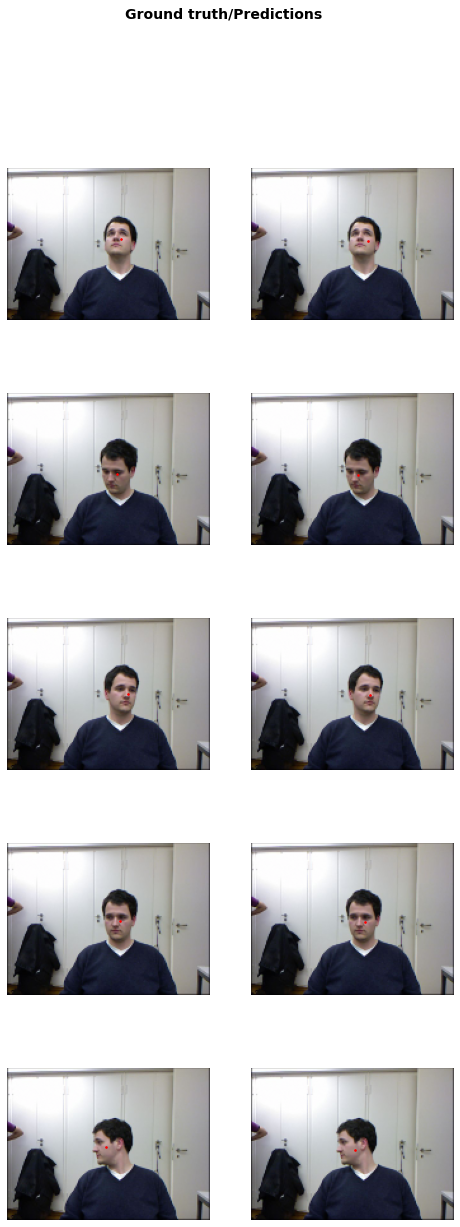

In [25]:
learn.show_results()

## Data augmentation

In [26]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:272: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.

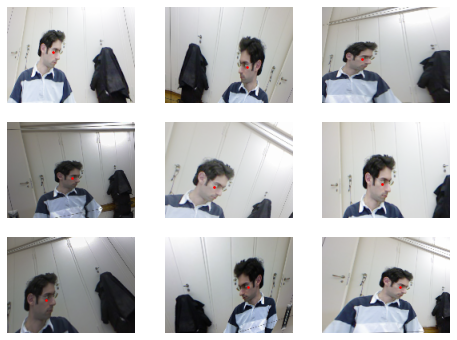

In [27]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))